# Classification of paddy rice over Thai Binh in Vietnam

* Exploring time series data for classification

In [1]:
import os
import sys
import itertools
import glob

import numpy as np
import pandas as pd
from osgeo import gdal, gdal_array, osr, ogr

from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix

from scipy import ndimage
import scipy

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1

import seaborn as sns

In [2]:
sns.set_context("paper")
sns.set_style("whitegrid")
dpi = 300

In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False) # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook
import plotly.tools

In [4]:
gdal.AllRegister()

In [5]:
cls_training_roi_asc_file = "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-field/classification_training_data_pixel.txt"

# cls_img_file_list = [\
#                      "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-cls/vietnam_thai_bin_cls_rf_lsat_scenes.img", \
#                      "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-cls/vietnam_thai_bin_cls_rf_sg_ndvi.img"]

cls_img_file_list = [ \
                     "/media/sf_Workspace/data/projects/kaiyu-adb-crop/vietnam-cls/vietnam_thai_bin_cls_rf_lsat_scenes.tif", \
                     "/media/sf_Workspace/data/projects/kaiyu-adb-crop/vietnam-cls/vietnam_thai_bin_cls_rf_sg_ndvi.tif"]

cls_img_label_list = [\
                      "SR_3_Scenes", \
                      "NDVI_TS_SG"]

cls_rnd_sample_shapefile = "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-cls/vietnam_thai_bin_cls_rf_lsat_scenes_rnd_samples.shp"

## Read classification image

In [6]:
from classify_image import ImageClassifier

In [7]:
ic = ImageClassifier()

In [9]:
cls_map_profile_list = [ic.getRasterProfile(cif) for cif in cls_img_file_list]
# ncls_list = [int(cls_map_profile['Metadata']['ENVI']['classes']) - 1 for cls_map_profile in cls_map_profile_list]
ncls_list = [6, 6]

no_data = 0

In [10]:
# cls_map, _ = ic.readRaster(cls_img_file)
# cls_map = cls_map[0]
# cls_map_masked = np.ma.masked_equal(cls_map, 0)
cls_map_list = [ic.readRaster(cif)[0][0] for cif in cls_img_file_list]
cls_map_masked_list = [np.ma.masked_equal(cm, no_data) for cm in cls_map_list]

## Read training data and visualize the distribution

In [11]:
ic.readImageData(cls_img_file_list[0])
ic.readTrainingData(cls_training_roi_asc_file)

In [12]:
px, py = np.unravel_index(ic.traindata['flat_ind'], ic.traindata['dims'], order='C')
label_image = np.zeros(ic.traindata['dims'], dtype=ic.traindata['y'].dtype)
label_image[px, py] = ic.traindata['y']

no_data = 0

tmp_flag = label_image != no_data
px, py = np.where(tmp_flag)

markers = np.zeros_like(label_image)
markers[tmp_flag] = 1
patch, npat = ndimage.label(markers, structure=np.ones((3, 3)))

In [13]:
patch_label = np.zeros(npat)
patch_npix = np.zeros(npat)
for i in range(npat):
    tmpflag = patch == i+1
    patch_npix[i] = np.sum(tmpflag)
    if len(np.unique(label_image[tmpflag])) > 1:
        print i
    patch_label[i] = np.mean(label_image[tmpflag])

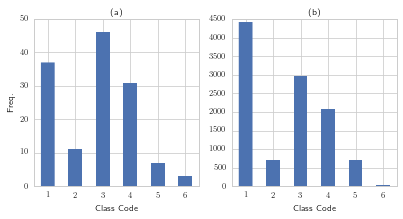

In [14]:
nlabels = len(np.unique(patch_label))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 3), sharex=True)
ax1.hist(patch_label, bins=np.arange(nlabels+1)+0.5, rwidth=0.5, edgecolor="none")
ax1.set_xlabel("Class Code")
ax1.set_ylabel("Freq.")
ax1.set_title("(a)")
ax1.set_xticks(np.arange(nlabels)+1)
ax2.hist(ic.traindata['y'], bins=np.arange(nlabels+1)+0.5, rwidth=0.5, edgecolor="none")
ax2.set_xlabel("Class Code")
# ax2.set_ylabel("Freq.")
ax2.set_title("(b)")

plt.savefig("../figures/training_data_distribution.png", dpi=dpi, pad_inches=0., \
            bbox_inches='tight')

In [26]:
np.sum(patch_label==6)

3

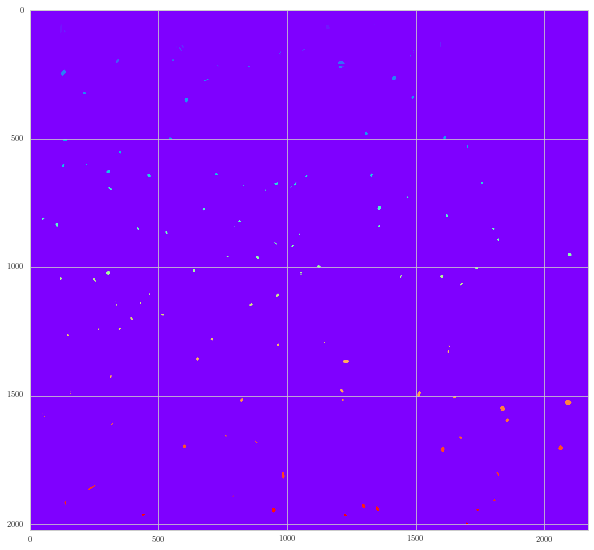

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(patch, cmap=plt.get_cmap("rainbow", npat))

## Plot the input images and output classification

In [10]:
figsize = (10, 10)

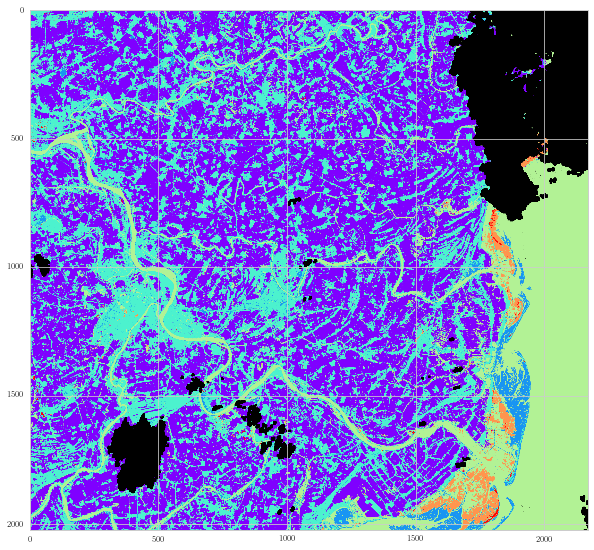

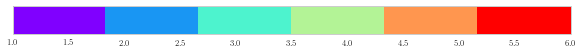

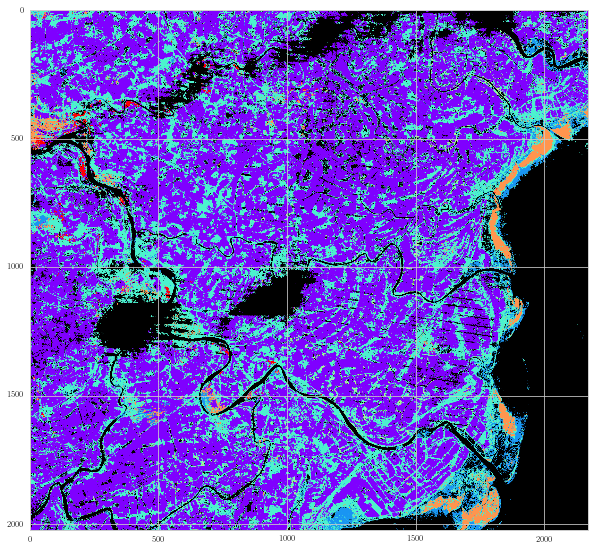

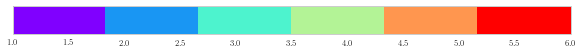

In [11]:
for n, cls_map_masked in enumerate(cls_map_masked_list):
    fig, ax = plt.subplots(figsize=figsize)

    # cm_used = plt.cm.rainbow
    cm_used = plt.get_cmap("rainbow", ncls_list[n])

    cm_used.set_bad('k')
    imobj = ax.imshow(cls_map_masked, cmap=cm_used)

    fig, ax = plt.subplots(figsize=(figsize[0], figsize[0]/20.))
    fig.colorbar(imobj, cax=ax, orientation="horizontal")

## Inspect the difference between the classification images

In [12]:
all_valid_flag = np.all(np.stack([cm!=0 for cm in cls_map_list], axis=2), axis=2)

In [13]:
cls_diff_list = [cm[all_valid_flag]!=cls_map_list[0][all_valid_flag] for cm in cls_map_list]

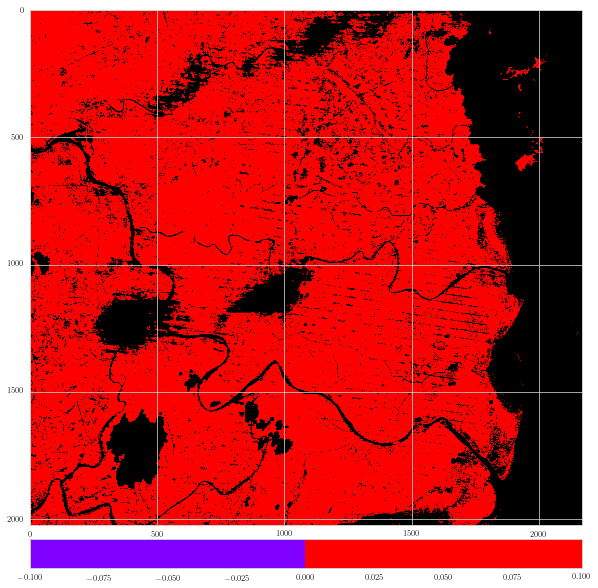

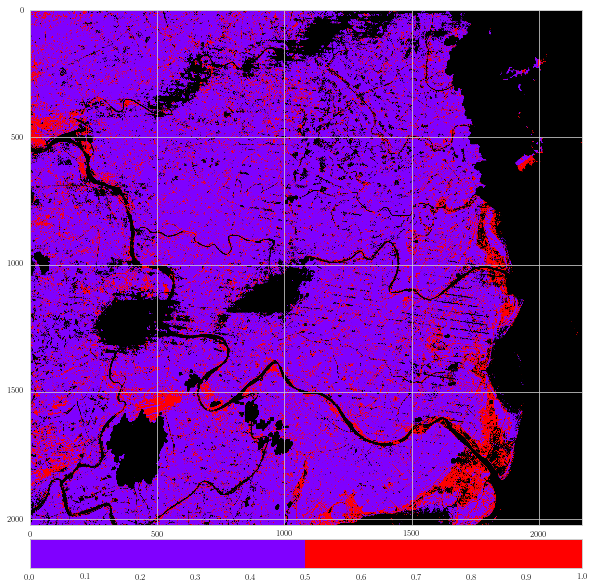

In [14]:
for n, cls_diff in enumerate(cls_diff_list):
    cls_diff_map = np.zeros_like(cls_map_list[0])
    cls_diff_map[all_valid_flag] = cls_diff
    cls_diff_map_masked = np.ma.masked_where(np.logical_not(all_valid_flag), cls_diff_map)
    
    fig, ax = plt.subplots(figsize=figsize)
    # cm_used = plt.cm.rainbow
    cm_used = plt.get_cmap("rainbow", 2)
    cm_used.set_bad('k')
    imobj = ax.imshow(cls_diff_map_masked, cmap=cm_used)
    
    divider = axes_grid1.make_axes_locatable(ax)
    cm_ax = divider.append_axes("bottom", 0.4, pad=0.2)
    fig.colorbar(imobj, cax=cm_ax, ax=cm_ax, orientation="horizontal")

In [15]:
cls_name_list = cls_map_profile_list[0]['Metadata']['ENVI']['class_names'].strip('{}').split(',')[1:]

In [16]:
con_mat = confusion_matrix(cls_map_list[0][all_valid_flag], cls_map_list[1][all_valid_flag], labels=np.arange(ncls_list[0])+1)

con_mat = pd.DataFrame(con_mat, index=["{0:s}_{1:s}".format(cn, cls_img_label_list[0]) for cn in cls_name_list], 
                       columns=["{0:s}_{1:s}".format(cn, cls_img_label_list[1]) for cn in cls_name_list])

In [17]:
con_mat

,croplands_NDVI_TS_SG,barren_NDVI_TS_SG,urban_and_built_up_NDVI_TS_SG,water_bodies_NDVI_TS_SG,wetlands_NDVI_TS_SG,natural_terrestrial_veg_NDVI_TS_SG
croplands_SR_3_Scenes,1757664,1655,46725,2132,1698,8470
barren_SR_3_Scenes,4008,26368,19327,1333,629,32
urban_and_built_up_SR_3_Scenes,124856,17537,780361,25416,24974,4361
water_bodies_SR_3_Scenes,16239,38927,98318,9398,3064,34
wetlands_SR_3_Scenes,599,3915,11402,478,26837,44
natural_terrestrial_veg_SR_3_Scenes,1013,111,357,0,2534,340


## Write difference to raster file 

In [18]:
cls_diff_file = "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-cls/cls_diff.img"

no_data = -9999
cls_diff_map = np.zeros_like(cls_map_list[0], dtype=np.int32)
cls_diff_map[all_valid_flag] = cls_diff_list[1]
cls_diff_map[np.logical_not(all_valid_flag)] = no_data
cls_diff_map = cls_diff_map.astype(np.int32)
driver = gdal.GetDriverByName("ENVI")
out_ds = driver.Create(cls_diff_file, \
                       cls_diff_map.shape[1], cls_diff_map.shape[0], 1, \
                       gdal_array.NumericTypeCodeToGDALTypeCode(cls_diff_map.dtype.type))
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(cls_diff_map)
out_band.SetDescription("Classification Different between {0:s} and {1:s}".format(cls_img_file_list[0], cls_img_file_list[1])) # set band name
out_band.SetNoDataValue(no_data)
out_band.FlushCache()

out_ds.SetGeoTransform(cls_map_profile_list[0]['GeoTransform'])
out_ds.SetProjection(cls_map_profile_list[0]['ProjectionRef'])

out_ds = None

## Designate which class map to use

In [19]:
n = 0
cls_map = cls_map_list[n]
no_data = 0
cls_map_profile = cls_map_profile_list[n]

In [20]:
cls_map_profile

{'DataType': [numpy.uint8],
 'GeoTransform': (610905.0, 30.0, 0.0, 2295345.0, 0.0, -30.0),
 'Metadata': {'': {'Band_1': 'Classification by Random Forest'},
  'ENVI': {'band_names': '{Classification by Random Forest}',
   'bands': '1',
   'bands_for_classification': '{"1 2 3 4 5 6", "1 2 3 4 5 6", "1 2 3 4 5 6"}',
   'byte_order': '0',
   'class_lookup': '{127, 0, 255, 42, 127, 246, 42, 220, 220, 127, 255, 180, 212, 220, 127, 255, 127, 65, 255, 0, 0}',
   'class_names': '{no_data, croplands, barren, urban_and_built_up, water_bodies, wetlands, natural_terrestrial_veg}',
   'classes': '7',
   'coordinate_system_string': '{PROJCS["WGS_1984_UTM_Zone_48N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0]

In [21]:
cls_code = np.arange(int(cls_map_profile['Metadata']['ENVI']['classes'])-1, dtype=np.int8)+1
cls_name = cls_map_profile['Metadata']['ENVI']['class_names'].strip('{}').split(',')[1:]
cls_npix = np.array([np.sum(cls_map==cls) for cls in cls_code])
total_npix = np.sum(cls_npix)
cls_w = cls_npix / float(total_npix)
print cls_code
print cls_name
print cls_npix
print cls_w

[1 2 3 4 5 6]
[' croplands', ' barren', ' urban_and_built_up', ' water_bodies', ' wetlands', ' natural_terrestrial_veg']
[1901126  105711 1204497  729353   47654    4617]
[ 0.47611971  0.02647436  0.30165531  0.18265982  0.01193451  0.00115629]


## Stratified random sampling for accuracy assessment

In [22]:
# expected user's accuracy for the classes
cls_u_hat = np.array([0.90, 0.70, 0.85, 0.95, 0.95, 0.50])
# standard error of the estimated overall accuracy
se_overall = 0.01
# standard error of the estimated user's accuracy for each class
cls_se = np.array([0.01, 0.05, 0.05, 0.02, 0.05, 0.10])
# expected sample size for each class to achieve the standard error given the expected user's accuracy
cls_nsamples_hat = np.round(cls_u_hat * (1-cls_u_hat) / cls_se**2 + 1).astype(int)
print cls_nsamples_hat
print np.sum(cls_nsamples_hat)

# total sample size
total_nsamples = int(np.sum(np.sqrt(cls_u_hat*(1.0-cls_u_hat))*cls_w / se_overall)**2)
print total_nsamples

# proportional sample size for each class
cls_nsamples = np.round(total_nsamples * cls_w).astype(int)
print cls_nsamples

nsamples_alc1 = 50
cls_nsamples = np.round((total_nsamples - len(cls_code)*nsamples_alc1) * cls_w + nsamples_alc1).astype(int)
print cls_nsamples

# now the expected SE given the number of samples for each class and the expected user's accuracy
cls_se_hat = np.sqrt(cls_u_hat * (1-cls_u_hat) / (cls_nsamples - 1))
print cls_se_hat

[901  85  52 120  20  26]
1204
934
[445  25 282 171  11   1]
[352  67 241 166  58  51]
[ 0.01601282  0.05640761  0.02304886  0.01696699  0.02886751  0.07071068]


In [23]:
# cls_map[cls_map==no_data] = 0

# # Given a marker image, i.e. image with only foreground and background, 
# # generate inclusion probablity of each foreground pixel
# marker_image = cls_map == cls_code[0]
# marker_opened = ndimage.morphology.binary_opening(marker_image, structure=np.ones((3, 3)), iterations=1)
# scipy.misc.imsave("../figures/tmp_cls1_opened.tiff", marker_opened)
# print np.sum(marker_opened>0)
# print np.sum(np.logical_and(marker_image, marker_opened))
# patch, npat = ndimage.label(marker_opened, structure=np.ones((3, 3)))
# print npat
# valid_pix_flag = patch > 0
# # get the number of pixels for each patch
# patch_npix = np.zeros(npat)
# for p in np.arange(npat, dtype=int)+1:
#     tmp_flag = patch == p
#     patch_npix[p-1] = np.sum(tmp_flag)
# print patch_npix

# pat_incl_prob = np.zeros_like(patch_npix, dtype=float)
# pat_incl_prob = patch_npix / np.sum(patch_npix)

# nsamples = cls_nsamples[0]
# # sample patch first
# if npat > nsamples:
#     pat_rnd_idx = np.random.choice(npat, nsamples, replace=False)
# else:
#     pat_rnd_idx = np.random.choice(npat, nsamples, replace=True)

# select_pat_idx, select_pat_cnt = np.unique(pat_rnd_idx, return_counts=True)

In [24]:
cls_rnd_rows = [None for n in range(len(cls_code))]
cls_rnd_cols = [None for n in range(len(cls_code))]
for n in range(len(cls_code)):
    tmpr, tmpc = np.where(cls_map==cls_code[n])
    if cls_nsamples[n] < len(tmpr):
        tmpidx = np.random.choice(len(tmpr), cls_nsamples[n], replace=False)
    else:
        tmpidx = np.arange(len(tmpr))
    cls_rnd_rows[n] = tmpr[tmpidx]
    cls_rnd_cols[n] = tmpc[tmpidx]
cls_rnd_rows = np.concatenate(cls_rnd_rows)
cls_rnd_cols = np.concatenate(cls_rnd_cols)

In [25]:
def pixel2Proj(geoMatrix, sample, line):
    """
    Covnert pixel location (sample, line), 
    with 0 being the first pixel, to the 
    geospatial coordinates in the projection system, 
    with (x, y) being the UL corner of the pixel.
    """
    ulX = geoMatrix[0]
    ulY = geoMatrix[3]
    xDist = geoMatrix[1]
    yDist = geoMatrix[5]
    rtnX = geoMatrix[2]
    rtnY = geoMatrix[4]
    x = sample * xDist + ulX
    y = line * yDist + ulY
    return (x, y)

def proj2Geo(filename, x, y):
    """
    Convert projected coordinates to geographic coordinates
    given the input raster file    
    """
    ds = gdal.Open(filename, gdal.GA_ReadOnly)
    in_sr = osr.SpatialReference()
    in_sr.ImportFromWkt(ds.GetProjectionRef())
    out_sr = in_sr.CloneGeogCS()
    coord_trans = osr.CoordinateTransformation(in_sr, out_sr)
    return coord_trans.TransformPoint(x, y)[0:2]

## Write the random samples to a shapefile of points

In [26]:
cls_rnd_x, cls_rnd_y = zip(*[pixel2Proj(cls_map_profile['GeoTransform'], s+0.5, l+0.5) for s, l in zip(cls_rnd_cols, cls_rnd_rows)])
cls_rnd_lon, cls_rnd_lat = zip(*[proj2Geo(cls_img_file_list[0], x, y) for x, y in itertools.izip(cls_rnd_x, cls_rnd_y)])

In [27]:
# # set up the shapefile driver
# driver = ogr.GetDriverByName("ESRI Shapefile")

# # create the data source
# data_source = driver.CreateDataSource(cls_rnd_sample_shapefile)

# # create the spatial reference, WGS84
# srs = osr.SpatialReference()
# srs.ImportFromWkt(cls_map_profile['ProjectionRef'])

# layer = data_source.CreateLayer("cls_rnd_samples", srs, ogr.wkbPoint)
# # Length of field name cannot be more than 10 characters for ESRI shapefile
# field = ogr.FieldDefn("Name", ogr.OFTString)
# field.SetWidth(16)
# layer.CreateField(field)
# layer.CreateField(ogr.FieldDefn("Latitude", ogr.OFTReal))
# layer.CreateField(ogr.FieldDefn("Longitude", ogr.OFTReal))
# layer.CreateField(ogr.FieldDefn("Sample", ogr.OFTInteger))
# layer.CreateField(ogr.FieldDefn("Line", ogr.OFTInteger))
# layer.CreateField(ogr.FieldDefn("PriRefCode", ogr.OFTInteger))
# layer.CreateField(ogr.FieldDefn("SecRefCode", ogr.OFTInteger))
# layer.CreateField(ogr.FieldDefn("MixFlag", ogr.OFTInteger))

# # Process the text file and add the attributes and features to the shapefile
# for n in range(len(cls_rnd_rows)):
#     # create the feature
#     feature = ogr.Feature(layer.GetLayerDefn())
#     # Set the attributes
#     feature.SetField("Name", "{0:d}".format(n+1))
#     feature.SetField("Latitude", cls_rnd_lat[n])
#     feature.SetField("Longitude", cls_rnd_lon[n])
#     feature.SetField("Sample", cls_rnd_cols[n])
#     feature.SetField("Line", cls_rnd_rows[n])
    
#     # create the WKT for the feature using Python string formatting
#     wkt = "POINT({0:f} {1:f})".format(float(cls_rnd_x[n]), float(cls_rnd_y[n]))

#     # Create the point from the Well Known Txt
#     point = ogr.CreateGeometryFromWkt(wkt)

#     # Set the feature geometry using the point
#     feature.SetGeometry(point)
#     # Create the feature in the layer (shapefile)
#     layer.CreateFeature(feature)
#     # Destroy the feature to free resources
#     feature.Destroy()

# # Destroy the data source to free resources
# data_source.Destroy()

In [28]:
# cls_rnd_sample_shapefile

In [29]:
%%bash
# ogr2ogr -f KML "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-cls/vietnam_thai_bin_cls_rf_lsat_scenes_rnd_samples.kml" "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-cls/vietnam_thai_bin_cls_rf_lsat_scenes_rnd_samples.shp"

## Read updated shapefile with reference labels

In [30]:
driver = ogr.GetDriverByName("ESRI Shapefile")
data_src = driver.Open(cls_rnd_sample_shapefile, 0)
layer = data_src.GetLayer()

npts = layer.GetFeatureCount()
layer_def = layer.GetLayerDefn()
nfields = layer_def.GetFieldCount()
# get name of fields
field_names = [layer_def.GetFieldDefn(i).GetName() for i in range(nfields)]
# set up a pandas dataframe to read the feature attributes
cls_ref_df = pd.DataFrame(np.zeros((npts, nfields)), columns=field_names)

for i, feature in enumerate(layer):
    tmp_list = [feature.GetField(fd) for fd in field_names]
    cls_ref_df.iloc[i, :] = np.array([0 if item is None else np.float(item) for item in tmp_list])

data_src.Destroy()

In [31]:
# Fill the secondary reference labels
tmp_flag = cls_ref_df['SecRefCode'] == 0
cls_ref_df.loc[tmp_flag, 'SecRefCode'] = cls_ref_df.loc[tmp_flag, 'PriRefCode']

In [32]:
cls_ref_df.head()

,Name,Latitude,Longitude,Sample,Line,PriRefCode,SecRefCode,MixFlag,RefConf,OtherCrop
0,1,20.660477,106.207378,495,343,1,1,1,3,0
1,2,20.491455,106.375470,1084,962,1,1,0,3,0
2,3,20.345870,106.156924,328,1505,1,1,0,3,0
3,4,20.753177,106.167197,353,2,1,1,0,3,0
4,5,20.617441,106.274691,730,500,1,1,1,3,0


In [33]:
# Get the classification labels
cls_ref_df['ClsCode'] = cls_map[cls_ref_df['Line'].astype(int), cls_ref_df['Sample'].astype(int)]

In [34]:
# Get the confusion matrix using the primary reference labels
con_mat = confusion_matrix(cls_ref_df['PriRefCode'], cls_ref_df['ClsCode'], labels=cls_code)

In [127]:
con_mat.T

array([[346,   1,   1,   1,   0,   3],
       [  3,  59,   4,   1,   0,   0],
       [ 38,  14, 159,   7,   0,  22],
       [  3,   2,   0, 158,   1,   2],
       [  0,   1,   0,  16,  40,   1],
       [  7,   0,   0,   4,  23,  17]])

In [109]:
class AccReport():
    def __init__(self, con_mat_samp, cls_npix):
        """
        Parameters: **con_mat_samp**, *2D numpy array, shape [n_classes, n_classes]*
                      Sampling confusion matrix in terms of number of samples from 
                      sampling. Rows are mapped labels and columns are reference
                      labels.
                    **cls_npix**, *1D numpy array, shape [n_class]*
                      The marginal total number of pixels in map classes. 
        """
        self.con_mat_samp = con_mat_samp
        self.n_cls = len(con_mat_samp)
        self.cls_npix = cls_npix
        self.cls_w = cls_npix / float(np.sum(cls_npix))
        
        self.runReport()
        
    def runReport(self):
        """Run the accuracy assessment report. 
        """
        # calcualte population confusion matrix in terms of area proportion
        n_i_dot = np.sum(self.con_mat_samp, axis=1)
        self.con_mat_pop = np.tile((self.cls_w / n_i_dot).reshape((self.n_cls, 1)), (1, self.n_cls)) * self.con_mat_samp
        
        # calcualte user's accuracy
        p_i_dot = np.sum(self.con_mat_pop, axis=1)
        self.U = np.array([self.con_mat_pop[i, i]/p_i_dot[i] for i in range(self.n_cls)])
        # calculate user's accuracy standard error
        self.SU = np.sqrt(self.U * (1. - self.U) / (n_i_dot-1))
        
        # calculate overall accuracy
        self.O = reduce(lambda x, y: x+y, [self.con_mat_pop[i, i] for i in range(self.n_cls)])
        self.SO = np.sqrt(np.sum(self.cls_w**2 * self.U * (1.-self.U) / (n_i_dot-1)))
        
        # calculate producer's accuracy
        p_dot_j = np.sum(self.con_mat_pop, axis=0)
        self.P = np.array([self.con_mat_pop[i, i]/p_dot_j[i] for i in range(self.n_cls)])
        # calculate producer's accuracy standard error
        N_i_dot = self.cls_npix
        N_dot_j = np.tile((N_i_dot / n_i_dot.astype(float)).reshape((self.n_cls, 1)), (1, self.n_cls)) * self.con_mat_samp
        N_dot_j = np.sum(N_dot_j, axis=0)
        term1 = N_i_dot**2 * (1-self.P)**2 * self.U * (1.-self.U) / (n_i_dot - 1)
        
        term2 = N_i_dot**2 / n_i_dot.astype(float)
        term2 = np.tile(term2.reshape((self.n_cls, 1)), (1, self.n_cls)) * self.con_mat_samp
        term2 = term2 * (1 - self.con_mat_samp / np.tile(n_i_dot.reshape((self.n_cls, 1)), (1, self.n_cls)))
        term2 = term2 / np.tile(n_i_dot.reshape((self.n_cls, 1)), (1, self.n_cls))
        for i in range(self.n_cls):
            term2[i, i] = 0
        term2 = np.sum(term2, axis=0) * self.P**2
        self.SP = np.sqrt((term1 + term2) / N_dot_j**2)
        
        # calculate estimated proportion of area for classes adjusted for 
        # classification error based on our reference data
        self.p_dot_k = np.sum(self.con_mat_pop, axis=0)
        # calculate the standard error of the estimated area proportion
        tmp = np.tile(self.cls_w.reshape((self.n_cls, 1)), (1, self.n_cls)) * self.con_mat_pop - self.con_mat_pop**2
        tmp = tmp / (np.tile(n_i_dot.reshape((self.n_cls, 1)), (1, self.n_cls)) - 1)
        tmp = np.sum(tmp, axis=0)
        self.Sp_dot_k = np.sqrt(tmp)
        
        
    def getConMatPop(self):
        """Return the estimated population confusion matrix in terms of area 
        proportion.
        """
        return self.con_mat_pop
    
    def getUserAcc(self):
        return self.U, self.SU
    
    def getProducerAcc(self):
        return self.P, self.SP
    
    def getOverallAcc(self):
        return self.O, self.SO
    
    def getAreaPropErrAdjust(self):
        return self.p_dot_k, self.Sp_dot_k

In [131]:
cls_ar = AccReport(con_mat.T, cls_npix)

np.set_printoptions(precision=2, formatter={'float':lambda x: "{0:.2f}".format(x)})

print "Estimated population confusion matrix"
print cls_ar.getConMatPop()
print np.sum(cls_ar.getConMatPop())
print
print "User's accuracy"
print cls_ar.getUserAcc()[0], cls_ar.getUserAcc()[1]*1.96
print
print "Producer's accuracy"
print cls_ar.getProducerAcc()[0], cls_ar.getProducerAcc()[1]*1.96
print
print "Error-adjusted area proportion estimate"
print cls_ar.getAreaPropErrAdjust()[0], cls_ar.getAreaPropErrAdjust()[1]*1.96
print
print "Overall accuracy"
print cls_ar.getOverallAcc()[0], cls_ar.getOverallAcc()[1]*1.96
print
print "Area proportion from classification map"
print cls_w
print cls_name

Estimated population confusion matrix
[[0.47 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.02 0.00 0.00 0.00 0.00]
 [0.05 0.02 0.20 0.01 0.00 0.03]
 [0.00 0.00 0.00 0.17 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.01 0.00]
 [0.00 0.00 0.00 0.00 0.00 0.00]]
1.0

User's accuracy
[0.98 0.88 0.66 0.95 0.69 0.33] [0.01 0.08 0.06 0.03 0.12 0.13]

Producer's accuracy
[0.90 0.52 0.99 0.93 0.84 0.01] [0.03 0.12 0.01 0.04 0.19 0.01]

Error-adjusted area proportion estimate
[0.52 0.04 0.20 0.19 0.01 0.03] [0.02 0.01 0.02 0.01 0.00 0.01]

Overall accuracy
0.873636983445 0.0202634035927

Area proportion from classification map
[0.48 0.03 0.30 0.18 0.01 0.00]
[' croplands', ' barren', ' urban_and_built_up', ' water_bodies', ' wetlands', ' natural_terrestrial_veg']


In [117]:
# con_mat_test = np.array(\
#                         [[127, 66, 54], \
#                         [2, 322, 17], \
#                         [0, 15, 540]])
# cls_npix_test = np.round(np.array([7, 295, 698])*100)

# con_mat_test = np.array([\
#                         [97, 0, 3], \
#                         [3, 279, 18], \
#                         [2, 1, 97]])
# cls_npix_test = np.array([12, 640, 348])

con_mat_test = np.array([\
                        [66, 0, 5, 4], \
                        [0, 55, 8, 12], \
                        [1, 0, 153, 11], \
                        [2, 1, 9, 313]])
cls_npix_test = np.array([200000, 150000, 3200000, 6450000])

cls_ar = AccReport(con_mat_test, cls_npix_test)

In [119]:
print cls_ar.getConMatPop()
print np.sum(cls_ar.getConMatPop())
print cls_ar.getUserAcc()[0], cls_ar.getUserAcc()[1]*1.96
print cls_ar.getProducerAcc()[0], cls_ar.getProducerAcc()[1]*1.96
print cls_ar.getAreaPropErrAdjust()[0], cls_ar.getAreaPropErrAdjust()[1]
print
print cls_ar.getOverallAcc()[0], cls_ar.getOverallAcc()[1]*2

[[ 0.0176      0.          0.00133333  0.00106667]
 [ 0.          0.011       0.0016      0.0024    ]
 [ 0.00193939  0.          0.29672727  0.02133333]
 [ 0.00396923  0.00198462  0.01786154  0.62118462]]
1.0
[ 0.88        0.73333333  0.92727273  0.96307692] [ 0.07404098  0.10075701  0.03974537  0.0205335 ]
[ 0.7486614   0.8471564   0.93450891  0.96160899] [ 0.21353177  0.25440836  0.03476979  0.01895593]
[ 0.02350862  0.01298462  0.31752214  0.64598462] [ 0.00349072  0.00212915  0.00879242  0.00922996]

0.946511888112 0.0188608344312


In [41]:
# def matplotlib_to_plotly(cmap, pl_entries):
#     h = 1.0/(pl_entries-1)
#     pl_colorscale = []
    
#     for k in range(pl_entries):
#         C = map(np.uint8, np.array(cmap(k*h)[:3])*255)
#         pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
#     return pl_colorscale

# import plotly.plotly as ply
# import plotly.graph_objs as go

# data = [ \
#         go.Heatmap(z=np.flipud(cls_map_masked), colorscale=matplotlib_to_plotly(plt.cm.get_cmap('rainbow'), 6))]
# img_w = 800
# img_h = img_w * img_nline / float(img_nsample)

# layout = go.Layout( \
#                    xaxis=go.XAxis(range=[0, img_nsample-1]), \
#                    yaxis=go.YAxis(range=[0, img_nline-1]), \
#                    height=img_h, width=img_w)

# ifigure = go.Figure(data=data, layout=layout)
# iplot(ifigure)

In [42]:
def linear_stretch(arr, vmin, vmax):
    """
    Linear stretch of a 2D numpy array given the minimum and maximum.
    
    Returns:
        2D numpy array of uint8: stretched array of 0-255
    """
    outarr = ((arr - vmin) / (vmax - vmin) * 255).astype(np.uint8)
    outarr[outarr<0] = np.uint8(0)
    outarr[outarr>255] = np.uint8(255)
    return outarr

In [43]:
# imgdata_masked_list = [np.ma.masked_where(img==0, img) for img in imgdata_list]

# vmin, vmax = 0, 0.2
# rgb = np.stack((linear_stretch(imgdata_masked_list[2], vmin=vmin, vmax=vmax), \
#                 linear_stretch(imgdata_masked_list[1], vmin=vmin, vmax=vmax), \
#                 linear_stretch(imgdata_masked_list[0], vmin=vmin, vmax=vmax)), axis=2)

# fig, ax = plt.subplots(figsize=figsize)
# ax.imshow(rgb)

python classify_image.py -i "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-landsat-gapfilled/LC82015191" "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-landsat-gapfilled/LE72015103_filled_GNSPI_filled_GNSPI" "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-landsat-gapfilled/LE72015183_filled_GNSPI_filled_GNSPI" --trainF 1 --train "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-field/classification_training_data_pixel.txt" -c "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-cls/test_cls_python.img" --clsF "ENVI"